In [1]:
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import nltk
import json
from tqdm import tqdm
import ir_datasets
import pyterrier as pt
import random
import math
from collections import Counter
if not pt.started():
	pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])


C:\Users\yacin\AppData\Local\Temp\ipykernel_2652\23155782.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) started. (use pt.java.started() instead) -- Deprecated since version 0.11.0.
  if not pt.started():
Java started and loaded: pyterrier.java, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]
C:\Users\yacin\AppData\Local\Temp\ipykernel_2652\23155782.py:17: DeprecationWarning: Call to deprecated method pt.init(). Deprecated since version 0.11.0.
The following code will have the same effect:
pt.java.add_package('com.github.terrierteam', 'terrier-prf', '-SNAPSHOT')
pt.java.init() # optional, forces java initialisation
  pt.init(boot_packages=["com.github.terrierteam:terrier-prf:-SNAPSHOT"])


# A- Préparation des données et leur indexation

## A-1: making my dataset smaller so the indexation doesn't take days to run

In [2]:
import os
import shutil
import ir_datasets
import pyterrier as pt

# 1. Supprimer le cache local du dataset incriminé
#   - sous Linux/macOS : ~/.cache/ir_datasets
#   - sous Windows : C:\\Users\\<votre‑nom>\\.cache\\ir_datasets
cache_subpath = os.path.expanduser("~/.cache/ir_datasets/msmarco_document/trec-dl-hard")
shutil.rmtree(cache_subpath, ignore_errors=True)

# 2. Recharger le dataset (ir_datasets téléchargera alors les fichiers manquants)
dataset = ir_datasets.load("msmarco-document/trec-dl-hard")

# Vérification sommaire
qrels = set(qrel.doc_id for qrel in dataset.qrels_iter())
print(f"Nombre de documents pertinents (qrels) : {len(qrels)}")

# 3. (Re)lancer votre indexation
def iter_docs_filtered(alpha=1.0):
    for doc in dataset.docs_iter():
        yield {"docno": doc.doc_id, "text": doc.text}

indexer = pt.IterDictIndexer(
    "./index_msmarco",
    meta={'docno': 20, 'text': 4096},
    fields=True
)
indexref = indexer.index(iter_docs_filtered(alpha=1.0))
print(f"Indexation terminée : {indexref}")


Nombre de documents pertinents (qrels) : 8442


[INFO] Please confirm you agree to the MSMARCO data usage agreement found at <http://www.msmarco.org/dataset.aspx>
[INFO] If you have a local copy of https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz, you can symlink it here to avoid downloading it again: C:\Users\yacin\.ir_datasets\downloads\d4863e4f342982b51b9a8fc668b2d0c0
[INFO] [starting] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz
[INFO] [finished] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz: [07:22] [2.00GB] [4.51MB/s]
[WARNING] Download failed: Expected md5 hash to be d4863e4f342982b51b9a8fc668b2d0c0 but got 4236321b18dbafc32b2b25fc3c879daa


HashVerificationError: Expected md5 hash to be d4863e4f342982b51b9a8fc668b2d0c0 but got 4236321b18dbafc32b2b25fc3c879daa

In [6]:
indexer = pt.IterDictIndexer("./index_msmarco", meta={'docno': 20, 'text': 4096}, fields=True)

In [7]:
indexref = indexer.index(iter_docs_filtered(alpha=1))
print(f"Indexation terminée : {indexref}")

[INFO] If you have a local copy of https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz, you can symlink it here to avoid downloading it again: C:\Users\yacin\.ir_datasets\downloads\d4863e4f342982b51b9a8fc668b2d0c0
[INFO] [starting] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz
[INFO] [finished] https://msmarco.z22.web.core.windows.net/msmarcoranking/msmarco-docs.trec.gz: [11:30] [2.38GB] [3.46MB/s]
[WARNING] Download failed: Expected md5 hash to be d4863e4f342982b51b9a8fc668b2d0c0 but got e316b2f31dc32d2f85ea707fafffac0d


HashVerificationError: Expected md5 hash to be d4863e4f342982b51b9a8fc668b2d0c0 but got e316b2f31dc32d2f85ea707fafffac0d

## A-2: updating qrels and queries to correspond the new doc collection

In [7]:
qrels_df = pd.read_csv(
    "data/qrels.test", sep=" ",
    names=["qid","zero","docno","relevance"], dtype=str
)
display(qrels_df.head())

queries_df = pd.read_json("data/queries.test.jsonl", lines=True)
queries_df = queries_df.rename(columns={"query_id": "qid", "text": "query"})
queries_df["qid"] = queries_df["qid"].astype(str)
display(queries_df.head())

,qid,zero,docno,relevance
0,263,0,1990028700044315,3
1,263,0,1990047100022016,3
2,263,0,1990061800001166,3
3,263,0,1990075200077466,3
4,263,0,1990083600000244,3


,qid,query
0,263,calcio mercato
1,326,cotto e mangiato
2,381,lavatrici ad ultrasuoni
3,480,giallo zafferano
4,515,stipendi pa


In [5]:
# read data/kept_docnos.txt
with open("data/kept_docnos.txt", "r") as f:
	kept_docnos = set(line.strip() for line in f)

In [8]:
print(f"{len(kept_docnos)} docno récupérés de l'index (reproduction du filtre)")
#with open("data/kept_docnos.txt", "w") as f:
with open("data/kept_docnos.txt", "w") as f:
	for docno in kept_docnos:
		f.write(f"{docno}\n")

0 docno récupérés de l'index (reproduction du filtre)


In [8]:
# i'm updating qrels
qrels_df = qrels_df[qrels_df["docno"].isin(kept_docnos)]
qrels_df["relevance"] = qrels_df["relevance"].astype(int)
qrels_df.to_csv("data/kept_qrels.csv", index=False)
queries_df = queries_df[queries_df["qid"].isin(qrels_df["qid"])]
queries_df.to_csv("data/kept_queries.csv", index=False)
print(f"{len(qrels_df)}  qrel saved")
print(f"{len(queries_df)}  queries saved")

594  qrel saved
234  queries saved


In [9]:
qrels = {(row["qid"], row["docno"]): row["relevance"] for _, row in qrels_df.iterrows()}
print(f"Qrels :", qrels)

Qrels : {('594', '1990131000007252'): 3, ('680', '1990018100303455'): 3, ('680', '1990089200000157'): 1, ('1168', '1990083002539704'): 4, ('1327', '1990119500892034'): 3, ('2217', '1990022900501496'): 4, ('2217', '1990084602539290'): 4, ('3615', '1990052900015840'): 1, ('3873', '1990116900679458'): 1, ('4797', '1990078801259321'): 3, ('4797', '1990139400016103'): 1, ('4933', '1990071602540234'): 1, ('4933', '1990093402538496'): 1, ('4933', '1990097202541632'): 1, ('4933', '1990106602544080'): 1, ('4933', '1990121902541574'): 1, ('4933', '1990137800453992'): 1, ('4933', '1990155902534081'): 1, ('5061', '1990128400160708'): 1, ('5061', '1990129302540757'): 4, ('5262', '1990023000000837'): 3, ('5262', '1990040601523702'): 3, ('5262', '1990055000702701'): 1, ('5262', '1990060001646608'): 1, ('5262', '1990128700924146'): 1, ('6534', '1990022601270316'): 1, ('7525', '1990133802538127'): 3, ('7684', '1990126700174684'): 3, ('7694', '1990069802543421'): 1, ('7694', '1990091902539049'): 1, ('76

# B - Stopping strategies

## B-0 extract hard and easy queries

In [11]:
index = pt.IndexFactory.of("index/data_1.properties")
pl2 = pt.terrier.Retriever(index, wmodel="PL2", num_results =1000, metadata=['docno'])
hard_query_ranking  = pl2.transform(queries_df)
avg_scores = (
    hard_query_ranking
    .groupby(["qid", "query"])["score"]
    .mean()
    .reset_index(name="avg_score")
)
hardest = avg_scores.sort_values("avg_score", ascending=True).head(50)
hardest[["qid", "query"]].to_csv("data/hard_queries.csv", index=False)
easiest = avg_scores.sort_values("avg_score", ascending=False).head(50)
easiest[["qid", "query"]].to_csv("data/easy_queries.csv", index=False)
display(hardest.shape, hardest.head(10))
display(easiest.shape, easiest.head(10))

(50, 3)

,qid,query,avg_score
75,3873,sinonimi e contrari,1.875155
17,17624,chianciano terme,2.887562
13,13571,tende a rullo,2.909435
97,42269,yasmine bleeth,2.910354
92,41683,tiffany toth,3.055847
165,66567,rizzoli e isles,3.109468
66,36959,canyon aeroad,3.163643
152,63485,pharma news,3.189995
83,39334,lindsey vonn,3.293854
181,73055,madagascar swamp warbler,3.293873


(50, 3)

,qid,query,avg_score
144,61157,monarcha melanopsis,17.614985
173,69694,aulacorhynchus sulcatus,17.354201
82,39191,lapo elkann,15.404765
120,54092,allevamenti trotto,13.544531
142,60906,poospiza cinerea,12.761345
160,65027,circaetus cinerascens,12.365471
157,64257,innesto a baionetta,12.318140
42,27486,membrana biocompatibile,10.435834
59,34043,pbg quarzi,10.161512
172,69183,cinereous antshrike,10.143439


## B-1 initial ranking

In [12]:
index = pt.IndexFactory.of("index/data_1.properties")
pl2 = pt.terrier.Retriever(index, wmodel="PL2", num_results =100, metadata=['docno', 'text'])
initial_ranking  = pl2.transform(queries_df)


In [13]:
initial_ranking.head(10)

,qid,docid,docno,text,rank,score,query
0,594,129013,1990131000007252,Video sportivi - Sport Mediaset,0,12.928206,mediaset video
1,594,56684,1990012301082193,nuova fiction mediaset | Spindle\n\nnuova fict...,1,11.860954,mediaset video
2,594,60702,1990066102541092,Video Amici: Francesco e Anbeta - You never ca...,2,11.591290,mediaset video
3,594,128971,1990126700174684,Video Tgcom24: Francesco Nuti da Barbara D'Urs...,3,11.494154,mediaset video
4,594,53153,1990012102481006,Cannes: Lionsgate Intl. Rolls Out ‘Marrowbone’...,4,10.046203,mediaset video
5,594,98506,1990011301631960,Prisa confirms appeal against Spanish DTT awar...,5,9.050257,mediaset video
6,594,41143,1990011602091449,Shroud of the Avatar Streaming on a Nexus Play...,6,8.132299,mediaset video
7,594,100768,1990011401264059,New Ooyala Study Shows Mobile Audiences Matter...,7,8.037220,mediaset video
8,594,55138,1990012202023484,Mancini: Inter’s loss to Lazio was stupid | Fo...,8,7.675206,mediaset video
9,594,1477,1990010001436487,Sportpesa » Chelsea will meet the agent of Eze...,9,7.559798,mediaset video


In [14]:
pt.Evaluate(initial_ranking, qrels_df, metrics=['map', "ndcg", "P"], perquery=False)

{'map': 0.6592542543732097,
 'ndcg': 0.7072426270693265,
 'P@5': 0.3324786324786329,
 'P@10': 0.20085470085470108,
 'P@15': 0.14358974358974338,
 'P@20': 0.11047008547008562,
 'P@30': 0.0769230769230769,
 'P@100': 0.023974358974358918,
 'P@200': 0.011987179487179459,
 'P@500': 0.004794871794871798,
 'P@1000': 0.002397435897435899}

## B-2 stopping transformations

In [15]:
meta = index.getMetaIndex()

def get_text_from_index(docid):
    return meta.getItem("text", int(docid))


In [ ]:
qrels = {
	(str(row.qid), str(row.docno)): int(row.relevance)
	for row in qrels_df.itertuples()
}

def apply_ss1(ranking, qid, x1):
	return ranking.iloc[:x1]

def apply_ss2(ranking, qid, x2):
	non_rel = 0
	kept_idx = []
	for idx, row in ranking.iterrows():
		kept_idx.append(idx)
		# On récupère la pertinence via le dict ; défaut 0 si absent
		rel = qrels.get((str(qid), str(row.docno)), 0)
		if rel == 0:
			non_rel += 1
		if non_rel >= x2:
			break
	return ranking.loc[kept_idx]

def apply_ss3(ranking, qid, x3):
	consec = 0
	kept_idx = []
	for idx, row in ranking.iterrows():
		kept_idx.append(idx)
		rel = qrels.get((str(qid), str(row.docno)), 0)
		if rel == 0:
			consec += 1
		else:
			consec = 0
		if consec >= x3:
			break
	return ranking.loc[kept_idx]


def apply_ss4(ranking, qid, x4):
	seen_terms = set()
	stop_at = None
	for idx, row in ranking.iterrows():
		terms_curr = set(row["text"].split())
		overlap = len(terms_curr & seen_terms) / max(len(terms_curr), 1)
		if overlap > x4:
			stop_at = idx
			break
		seen_terms |= terms_curr
	if stop_at is None:
		return ranking.copy()
	return ranking.loc[:stop_at]
from collections import Counter
import math

def apply_ss5(ranking, qid, x5):
	seen_counts = Counter()
	total_seen  = 0
	stop_at     = None

	for idx_row, row in ranking.iterrows():
		full_text  = get_text_from_index(row["docid"])
		words_curr = full_text.split()
		count_curr = Counter(words_curr)
		total_curr = sum(count_curr.values())
		P_curr     = {w: c/total_curr for w, c in count_curr.items()}
		P_prev = {w: seen_counts[w]/total_seen for w in seen_counts} if total_seen>0 else {}
		kl = sum(p * math.log(p / P_prev.get(w, 1e-15)) for w, p in P_curr.items())
		if kl < x5:
			stop_at = idx_row
			break
		seen_counts.update(count_curr)
		total_seen  += total_curr
	return ranking if stop_at is None else ranking.loc[:stop_at]


def apply_ss6(ranking, qid, x6, td=1.0, tq=2.0):
	cum_gain = 0.0
	stop_at = None
	for rank, row in ranking.iterrows():
		rel = qrels.get((str(qid), str(row.docno)), 0)
		cum_gain += (2**rel-1) / math.log2(rank + 2) 
		cost = rank * td + tq
		rate = cum_gain / cost

		if rank >= 4.0 and rate < x6:  # commencer à estimer après 2 documents
			stop_at = rank
			break

	if stop_at is None:
		return ranking.copy()
	return ranking.iloc[:stop_at+1]




## B-2 Le gain cumulatif moyen

In [163]:
def dcg_at_k(rels):
    return sum((2**rel -1)/(math.log2(idx+2)) for idx, rel in enumerate(rels))

def cg_at_k(rels):
    return sum(rels)

def average_dcg_and_avr_depth(stopping_function, x=0, initial_ranking=initial_ranking):
    total_dcg = 0.0
    total_depth = 0
    for qid in queries_df["qid"]:
        subrank = initial_ranking[initial_ranking["qid"] == qid] \
                    .sort_values("score", ascending=False)
        stopped = stopping_function(subrank, qid, x)
        docnos = stopped["docno"].tolist()
        relevs = [qrels.get((qid, docno)) for docno in docnos] # make zero if not found
        #relevs = [-1 if rel==0 else rel for rel in relevs]
        relevs = [-1 if rel is None else rel for rel in relevs]
        total_dcg  += dcg_at_k(relevs) 
        total_depth += len(docnos)
    return total_dcg / len(queries_df), total_depth / len(queries_df)


In [173]:
import json
import numpy as np
from tqdm import tqdm

x1_values = np.arange(1, 13, 1)
x2_values = np.arange(1, 8, 0.06)
x3_values = x2_values
x4_values = np.arange(0.1, 0.4, 0.02)
x5_values = np.arange(14, 25, 0.6)
#x6_values = np.arange(0.002, 0.1, 0.001*3)

N_RUNS = 1


raw = {
    "SS1": {"x": x1_values, "gains": [],  "depths": []},
    "SS2": {"x": x2_values, "gains": [],  "depths": []},
    "SS3": {"x": x3_values, "gains": [],  "depths": []},
    "SS4": {"x": x4_values, "gains": [],  "depths": []},
    "SS5": {"x": x5_values, "gains": [],  "depths": []}
}

strategies = {
	"SS1": apply_ss1,
    "SS2": apply_ss2,
    "SS3": apply_ss3,
    "SS4": apply_ss4,
    "SS5": apply_ss5
}

for run in range(N_RUNS):
    print(f"=== Run {run+1}/{N_RUNS} ===")
    for name, func in strategies.items():
        x_vals = raw[name]["x"]
        gains_run  = []
        depths_run = []
        for x in tqdm(x_vals, desc=name):
            cg, dp = average_dcg_and_avr_depth(func, x=x, initial_ranking=initial_ranking)
            gains_run.append(cg)
            depths_run.append(dp)
        raw[name]["gains"].append(gains_run)
        raw[name]["depths"].append(depths_run)

results = {}
for name in strategies:
    arr_gains  = np.array(raw[name]["gains"])   # shape (N_RUNS, len(x))
    arr_depths = np.array(raw[name]["depths"])
    mean_gains  = arr_gains.mean(axis=0).tolist()
    mean_depths = arr_depths.mean(axis=0).tolist()
    results[name] = {
        "x":   raw[name]["x"].tolist(),
        "gains":  mean_gains,
        "depths": mean_depths
    }

with open("results/avg_full_stopping_strategies_results_final.json", "w") as fp:
    json.dump(results, fp, indent=4)



=== Run 1/1 ===


SS5: 100%|██████████| 19/19 [00:15<00:00,  1.22it/s]


In [174]:
def plot(file="results/full_hard_stopping_strategies_results_final.json", title="title"):
	import matplotlib.pyplot as plt
	plt.figure(figsize=(5, 5))
	import seaborn as sns
	sns.set_style("whitegrid")
	with open(file, "r") as f:
		data = json.load(f)
		ss1_depths = data["SS1"]["depths"]
		ss1_gains = data["SS1"]["gains"]
		ss2_depths = data["SS2"]["depths"]	
		ss2_gains = data["SS2"]["gains"]
		ss3_depths = data["SS3"]["depths"]
		ss3_gains = data["SS3"]["gains"]
		ss4_depths = data["SS4"]["depths"]
		ss4_gains = data["SS4"]["gains"]
		ss5_depths = data["SS5"]["depths"]
		ss5_gains = data["SS5"]["gains"]
	

	sns.lineplot(x=ss1_depths, y=ss1_gains, label="SS1", marker='o')
	sns.lineplot(x=ss2_depths, y=ss2_gains, label="SS2", marker='D')
	sns.lineplot(x=ss3_depths, y=ss3_gains, label="SS3", marker='v')
	sns.lineplot(x=ss4_depths, y=ss4_gains, label="SS4", marker='^')
	sns.lineplot(x=ss5_depths, y=ss5_gains, label="SS5", marker='s')
	plt.xlabel("Mean Depth/Query")
	plt.ylabel("Mean CG")
	plt.title(title)
	plt.legend()
	plt.show()
 


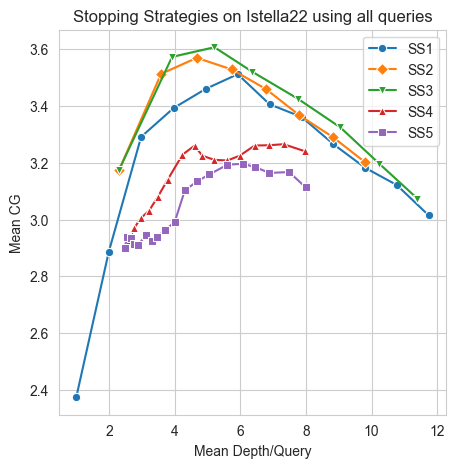

In [175]:
plot("results/avg_full_stopping_strategies_results_final.json", title = "Stopping Strategies on Istella22 using all queries")


## B-3 REDO with hard queries

In [152]:
hard_queries_df = pd.read_csv("data/hard_queries.csv")
index = pt.IndexFactory.of("index/data_1.properties")
pl2 = pt.terrier.Retriever(index, wmodel="PL2", num_results =100, metadata=['docno', 'text'])
initial_ranking_hard  = pl2.transform(hard_queries_df)

In [153]:
pt.Evaluate(initial_ranking_hard, qrels_df, metrics=['map', "ndcg", "P"], perquery=False)

{'map': 0.15294000282133258,
 'ndcg': 0.16485916881975543,
 'P@5': 0.0735042735042735,
 'P@10': 0.04230769230769229,
 'P@15': 0.029914529914529926,
 'P@20': 0.022435897435897422,
 'P@30': 0.01538461538461539,
 'P@100': 0.004700854700854703,
 'P@200': 0.0023504273504273516,
 'P@500': 0.0009401709401709405,
 'P@1000': 0.00047008547008547025}

In [154]:
import json
import numpy as np
from tqdm import tqdm

x1_values = np.arange(1, 13, 1)
x2_values = np.arange(1, 7, 0.2)
x3_values = x2_values
x4_values = np.arange(0.1, 0.4, 0.02)
x5_values = np.arange(14, 25, 0.6)
x6_values = np.arange(0.002, 0.03, 0.002)

N_RUNS = 3

raw = {
    "SS1": {"x": x1_values, "gains": [],  "depths": []},
    "SS2": {"x": x2_values, "gains": [],  "depths": []},
    "SS3": {"x": x3_values, "gains": [],  "depths": []},
    "SS4": {"x": x4_values, "gains": [],  "depths": []},
    "SS5": {"x": x5_values, "gains": [],  "depths": []}
    }

strategies = {
    "SS1": apply_ss1,
    "SS2": apply_ss2,
    "SS3": apply_ss3,
    "SS4": apply_ss4,
    "SS5": apply_ss5
    }

for run in range(N_RUNS):
    print(f"=== Run {run+1}/{N_RUNS} ===")
    for name, func in strategies.items():
        x_vals = raw[name]["x"]
        gains_run  = []
        depths_run = []
        for x in tqdm(x_vals, desc=name):
            cg, dp = average_dcg_and_avr_depth(func, x=x, initial_ranking=initial_ranking_hard)
            gains_run.append(cg)
            depths_run.append(dp)
        raw[name]["gains"].append(gains_run)
        raw[name]["depths"].append(depths_run)

results = {}
for name in strategies:
    arr_gains  = np.array(raw[name]["gains"])   # shape (N_RUNS, len(x))
    arr_depths = np.array(raw[name]["depths"])
    mean_gains  = arr_gains.mean(axis=0).tolist()
    mean_depths = arr_depths.mean(axis=0).tolist()
    results[name] = {
        "x":   raw[name]["x"].tolist(),
        "gains":  mean_gains,
        "depths": mean_depths
    }

with open("results/avg_hard_full_stopping_strategies_results_final.json", "w") as fp:
    json.dump(results, fp, indent=4)



=== Run 1/3 ===


SS5: 100%|██████████| 19/19 [00:05<00:00,  3.17it/s]


=== Run 2/3 ===


SS5: 100%|██████████| 19/19 [00:13<00:00,  1.42it/s]


=== Run 3/3 ===


SS5: 100%|██████████| 19/19 [00:10<00:00,  1.77it/s]


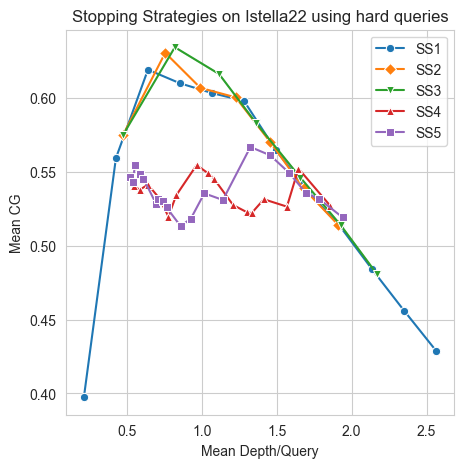

In [155]:
plot("results/avg_hard_full_stopping_strategies_results_final.json", title = "Stopping Strategies on Istella22 using hard queries")

## B-4 REDO with easy queries

In [246]:
easy_queries_df = pd.read_csv("data/easy_queries.csv")
index = pt.IndexFactory.of("index/data_1.properties")
pl2 = pt.terrier.Retriever(index, wmodel="PL2", num_results =100, metadata=['docno', 'text'])
initial_ranking_easy  = pl2.transform(easy_queries_df)

In [247]:
pt.Evaluate(initial_ranking_easy, qrels_df, metrics=['map', "ndcg", "P"], perquery=False)

{'map': 0.16586629528572638,
 'ndcg': 0.16784325516237625,
 'P@5': 0.09145299145299142,
 'P@10': 0.05598290598290596,
 'P@15': 0.039031339031339034,
 'P@20': 0.030341880341880338,
 'P@30': 0.0207977207977208,
 'P@100': 0.006367521367521371,
 'P@200': 0.0031837606837606855,
 'P@500': 0.001273504273504274,
 'P@1000': 0.000636752136752137}

In [ ]:
import json
import numpy as np
from tqdm import tqdm

x1_values = np.concatenate((np.arange(1, 20, 1), np.arange(20, 50, 4)))
x2_values = x1_values
x3_values = x1_values
x4_values = np.arange(0.1, 1.0, 0.05)
x5_values = np.arange(3.0, 10, 0.5)
x6_values = np.arange(0.0001, 0.06, 0.002)

N_RUNS = 3

raw = {
    "SS1": {"x": x1_values, "gains": [],  "depths": []},
    "SS2": {"x": x2_values, "gains": [],  "depths": []},
    "SS3": {"x": x3_values, "gains": [],  "depths": []},
    "SS4": {"x": x4_values, "gains": [],  "depths": []},
    "SS5": {"x": x5_values, "gains": [],  "depths": []}
    }

strategies = {
    "SS1": apply_ss1,
    "SS2": apply_ss2,
    "SS3": apply_ss3,
    "SS4": apply_ss4,
    "SS5": apply_ss5
    }

for run in range(N_RUNS):
    print(f"=== Run {run+1}/{N_RUNS} ===")
    for name, func in strategies.items():
        x_vals = raw[name]["x"]
        gains_run  = []
        depths_run = []
        for x in tqdm(x_vals, desc=name):
            cg, dp = average_dcg_and_avr_depth(func, x=x, initial_ranking=initial_ranking_easy)
            gains_run.append(cg)
            depths_run.append(dp)
        raw[name]["gains"].append(gains_run)
        raw[name]["depths"].append(depths_run)

results = {}
for name in strategies:
    arr_gains  = np.array(raw[name]["gains"])   # shape (N_RUNS, len(x))
    arr_depths = np.array(raw[name]["depths"])
    mean_gains  = arr_gains.mean(axis=0).tolist()
    mean_depths = arr_depths.mean(axis=0).tolist()
    results[name] = {
        "x":   raw[name]["x"].tolist(),
        "gains":  mean_gains,
        "depths": mean_depths
    }

with open("results/avg_easy_full_stopping_strategies_results_final.json", "w") as fp:
    json.dump(results, fp, indent=4)



=== Run 1/3 ===


SS5: 100%|██████████| 11/11 [00:31<00:00,  2.89s/it]


=== Run 2/3 ===


SS5: 100%|██████████| 11/11 [01:22<00:00,  7.55s/it]


=== Run 3/3 ===


SS5: 100%|██████████| 11/11 [01:10<00:00,  6.37s/it]


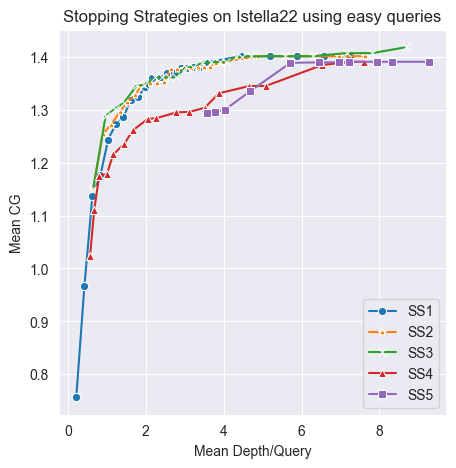

In [249]:
plot("results/avg_easy_full_stopping_strategies_results_final.json", title = "Stopping Strategies on Istella22 using easy queries")

# C- User Interaction

In [250]:
model1 = pt.BatchRetrieve(index, wmodel="BM25", num_results=1000, metadata=['docno', 'text'])
model2 = pt.BatchRetrieve(index, wmodel="PL2", num_results=1000, metadata=['docno', 'text'])
model3 = pt.BatchRetrieve(index, wmodel="TF_IDF", num_results=1000, metadata=['docno', 'text'])
model4 = pt.BatchRetrieve(index, wmodel="DFR_BM25", num_results=1000, metadata=['docno', 'text'])

results = pt.Experiment(
	[model1, model2, model3, model4],
	qrels=qrels_df,
	eval_metrics=["P", "recall"],
 	topics=hard_queries_df,
	perquery=False
)

C:\Users\yacin\AppData\Local\Temp\ipykernel_25156\3799656806.py:1: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  model1 = pt.BatchRetrieve(index, wmodel="BM25", num_results=1000, metadata=['docno', 'text'])
C:\Users\yacin\AppData\Local\Temp\ipykernel_25156\3799656806.py:2: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  model2 = pt.BatchRetrieve(index, wmodel="PL2", num_results=1000, metadata=['docno', 'text'])
C:\Users\yacin\AppData\Local\Temp\ipykernel_25156\3799656806.py:3: DeprecationWarning: Call to deprecated class BatchRetrieve. (use pt.terrier.Retriever() instead) -- Deprecated since version 0.11.0.
  model3 = pt.BatchRetrieve(index, wmodel="TF_IDF", num_results=1000, metadata=['docno', 'text'])
C:\Users\yacin\AppData\Local\Temp\ipykernel_25156\3799656806.py:4: DeprecationWarning: Call to deprecated class

In [251]:
results

,name,P@5,P@10,P@15,P@20,P@30,P@100,P@200,P@500,P@1000,R@5,R@10,R@15,R@20,R@30,R@100,R@200,R@500,R@1000
0,TerrierRetr(BM25),0.340,0.202,0.140000,0.106,0.072000,0.022,0.011,0.0044,0.0022,0.789286,0.908810,0.943810,0.947143,0.970476,0.977143,0.977143,0.977143,0.977143
1,TerrierRetr(PL2),0.344,0.198,0.140000,0.105,0.072000,0.022,0.011,0.0044,0.0022,0.797619,0.887143,0.942143,0.942143,0.968810,0.977143,0.977143,0.977143,0.977143
2,TerrierRetr(TF_IDF),0.344,0.204,0.141333,0.108,0.073333,0.022,0.011,0.0044,0.0022,0.792619,0.912143,0.947143,0.953810,0.977143,0.977143,0.977143,0.977143,0.977143
3,TerrierRetr(DFR_BM25),0.344,0.200,0.140000,0.106,0.072000,0.022,0.011,0.0044,0.0022,0.809286,0.897143,0.943810,0.947143,0.970476,0.977143,0.977143,0.977143,0.977143


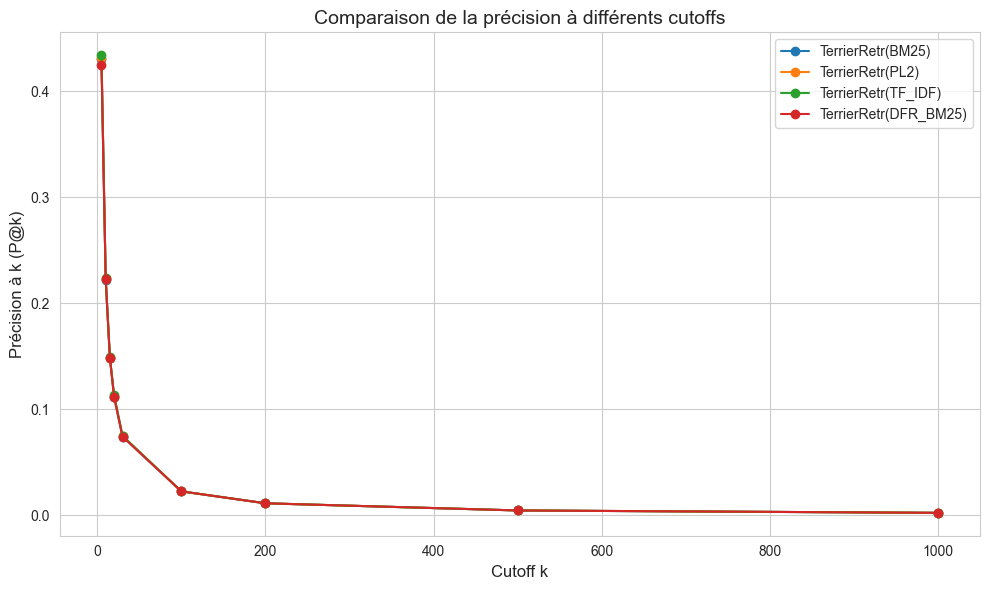

In [252]:
import matplotlib.pyplot as plt
names = results["name"]
p_cols = [col for col in results.columns if col.startswith("P@")]
r_cols = [col for col in results.columns if col.startswith("R@")]
ks = [int(col.split("@")[1]) for col in p_cols]  # extraire les k numériques pour l'axe des x
plt.figure(figsize=(10, 6))
for i in range(len(results)):
    label = results.loc[i, "name"]
    values = results.loc[i, p_cols].values
    values_r = results.loc[i, r_cols].values
    plt.plot(ks, values/values_r, marker='o', label=label)
plt.xlabel("Cutoff k", fontsize=12)
plt.ylabel("Précision à k (P@k)", fontsize=12)
plt.title("Comparaison de la précision à différents cutoffs", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
